In [1]:
#@title
import sys

In [2]:
#@title
!rm -rf DSACLine
!git clone https://github.com/sherwoac/DSACLine.git
path = "DSACLine"
if not path in sys.path:
    sys.path.insert(1, path)

Cloning into 'DSACLine'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 190 (delta 101), reused 97 (delta 41), pack-reused 22
Receiving objects: 100% (190/190), 1.46 MiB | 9.98 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [3]:
#@title
!rm -rf python-lrcurve
!git clone https://github.com/AndreasMadsen/python-lrcurve
path = "python-lrcurve"
if not path in sys.path:
    sys.path.insert(1, path)

Cloning into 'python-lrcurve'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 161 (delta 91), reused 127 (delta 58), pack-reused 0
Receiving objects: 100% (161/161), 3.45 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [4]:
#@title
# to facilitate command line default arguments
sys.argv = ['']
import main
opt = main.parser.parse_args()
import utils

import PIL.Image
import IPython.display
import ipywidgets

import numpy as np
import torch
import torchvision

from lrcurve import PlotLearningCurve

In [5]:
#@title
def prepare_data(opt, inputs, labels):
    # convert from numpy images to normalized torch arrays
    inputs = torch.tensor(inputs, requires_grad=True)
    labels = torch.tensor(labels, requires_grad=True)

    if not opt.cpu:
        inputs = inputs.cuda()

    inputs.transpose_(1, 3).transpose_(2, 3)
    inputs = inputs - 0.5 # normalization

    return inputs, labels

def visualize_dsac(val_images, val_labels, points, dsac):
    viz_dsac = dataset.draw_models(val_labels)
    viz_dsac = dataset.draw_points(points, viz_dsac, dsac.batch_inliers)
    viz_dsac = dataset.draw_models(dsac.est_parameters, viz_dsac, val_correct)
    viz_inputs = utils.make_grid(val_images)
    viz_dsac = utils.make_grid(viz_dsac)
    viz = torch.cat((viz_inputs, viz_dsac), 2)
    viz.transpose_(0, 1).transpose_(1, 2)
    viz /= viz.max()
    viz *= 255.
    viz = viz.to(torch.uint8).numpy()
    return viz

def make_visual_grid(samples):
    grid_samples = utils.make_grid(samples)
    grid_samples.transpose_(0, 1).transpose_(1, 2)
    grid_samples /= grid_samples.max()
    grid_samples *= 255.
    grid_samples = grid_samples.to(torch.uint8).numpy()
    return grid_samples

# Differentiable RANSAC example 

## Background
RANSAC - Random Sample Consensus is an algorithm based around the following principle:
- select subset of samples - hypothetical of _inliers_
- fit _provisional model_ to inliers
- rank all samples according to _provisional model_
- _refine model_ based on rankings - select new inliers
- repeat

cf [RANSAC wiki article](https://en.wikipedia.org/wiki/Random_sample_consensus)

## Dataset
In this toy example, **originally created by the Visual Learning Lab** [here](https://github.com/vislearn/DSACLine), straight lines are fitted to noisy data with distracting circles.

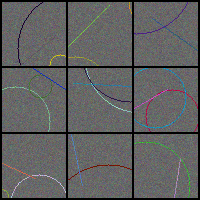

In [6]:
from line_dataset import LineDataset
dataset = LineDataset(opt.imagesize, opt.imagesize, max_sample_size=opt.batchsize)
val_images, val_labels = dataset.sample_lines(opt.valsize)
sample_images_grid = make_visual_grid(val_images)
image = PIL.Image.fromarray(sample_images_grid)
display(image)

## Network

The defined network is a fairly standard CNN that outputs Bx64x2 points, each representing a sampled guess for consumption by RANSAC.

In [7]:
from line_nn import LineNN
point_nn = LineNN(opt.capacity, opt.receptivefield)
print(point_nn)

LineNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

## Loss function

The loss function is very simple, it:
- takes line hypothesis (intercept and slope)
- finds the intercepts with a unit square
- finds the Euclidean distance between those intercepts for each hypothesis and the ground truth
- ...this encourages guesses along the line

In [8]:
from line_loss_aio import LineLossAio
loss_function = LineLossAio(image_size=opt.imagesize)

## Differentiable RANSAC

This follows the scheme laid out in the introduction:
- **sample hypotheses**:
    - take randoms pairs of points from the CNN, *p*
    - calculate the implied slopes and intercepts (hypotheses), *h*
- **generate inlier weightings**:
    - for each sampled point, *p* find the distance *d* to the hypothesised lines, *h*
    - the hypotheses, *h* generate scores *s* according to the sum of the (sigmoid) normalised distances
- **refine hypotheses**:
    - this step uses weighted [Deming regression](https://en.wikipedia.org/wiki/Deming_regression) to minimise the perpendicular distance of the points *p* to the lines, *h*, giving refined model hypotheses, **h*
- **weighted loss**:
    - the refined model hypotheses, **h*, are compared with the ground truth model, as described, *l*
    - this loss is a weighted sum according to the softmax normalised inlier scores, *s* multiplied by *l*

In [9]:
from dsac_aio import DsacAio
dsac = DsacAio(opt.hypotheses, opt.inlierthreshold, opt.inlierbeta, opt.inlieralpha, loss_function)

## Training

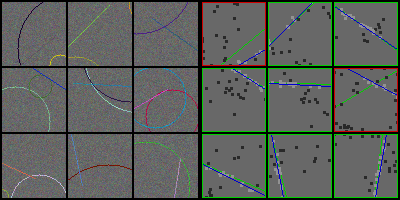

In [10]:
dh = display(display_id=True)

def plot_visual(viz):
  global dh
  image = PIL.Image.fromarray(viz)
  dh.display((image))

plot = PlotLearningCurve(
    mappings = {
        'exp_loss': { 'line': 'expected', 'facet': 'loss' },
        'top_loss': { 'line': 'top', 'facet': 'loss' },
        'val_acc': { 'line': 'accuracy', 'facet': 'val' },
    },
    facet_config = {
        'loss': { 'name': 'Loss', 'limit': [0, None], 'scale': 'linear' },
        'val': { 'name': 'Accuracy', 'limit': [0, 100.], 'scale': 'linear' },
    },
    xaxis_config = { 'name': 'Epoch', 'limit': [0, opt.trainiterations] },
    
    line_config = {
        'expected': { 'name': 'expected', 'color': '#F8766D' },
        'top': { 'name': 'top', 'color': '#00BFC4' },
        'accuracy': { 'name': 'accuracy', 'color': '#DDBFC4' }
    },
)

opt_point_nn = torch.optim.Adam(point_nn.parameters(), lr=opt.learningrate)
lrs_point_nn = torch.optim.lr_scheduler.StepLR(opt_point_nn, opt.lrstep, gamma=0.5)

point_nn = point_nn.cuda()
point_nn.train()

val_inputs, val_labels = utils.prepare_data(opt, val_images, val_labels)
with plot:
    for iteration in range(opt.trainiterations+1):
        opt_point_nn.zero_grad()
        batch_images, batch_labels = dataset.sample_lines(opt.batchsize)
        inputs, labels = prepare_data(opt, batch_images, batch_labels)
        point_prediction = point_nn(inputs)
        exp_loss, top_loss = dsac.calculate_loss(point_prediction, labels.cuda())
        exp_loss.backward()
        opt_point_nn.step()
        lrs_point_nn.step()
        plot.append(iteration, {
            'exp_loss': exp_loss,
            'top_loss': top_loss,
        })
        if iteration % int(opt.storeinterval) == 0:
            point_nn.eval()
            val_prediction = point_nn(val_inputs)
            val_exp, val_top = dsac.calculate_loss(val_prediction, val_labels.cuda())
            val_correct = dsac.est_losses < opt.valthresh
            plot.append(iteration, {
            'val_acc': 100. * val_correct.sum().cpu().item() / val_correct.size()[0],
            })
            points = val_prediction.cpu()
            viz = visualize_dsac(val_images, val_labels, points, dsac)
            plot_visual(viz)
            point_nn.train()
        
        plot.draw()